In [1]:
from typing import List, Optional
from torch.optim.optimizer import Optimizer

import os
import hydra
from torch import nn
from omegaconf import DictConfig
import pytorch_lightning as pl
from pytorch_lightning import (
    Callback,
    LightningDataModule,
    LightningModule,
    Trainer,
    seed_everything,
)
from pytorch_lightning.loggers import LightningLoggerBase
from PIL import Image
import  numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from src.utils import utils
from hydra import compose, initialize
from omegaconf import OmegaConf
from src.metrics.bounding_box import BoundingBox
from src.metrics.enumerators import BBType, CoordinatesType, BBFormat, MethodAveragePrecision
from src.metrics.pascal_voc_evaluator import get_pascalvoc_metrics, get_metrics
from enum import Enum

# GlobalHydra.instance().clear()
initialize(config_path="../configs/", job_name="test_app")

hydra.initialize()

In [2]:
config = compose(config_name="experiments/pest-detection-ssd/debug/overfit-lite.yaml", overrides=[])

In [3]:
datamodule: LightningDataModule = hydra.utils.instantiate(config.datamodule, data_config = config.datamodule, batch_size = 32, _recursive_=False)
datamodule.setup()

In [4]:
from src.data.utils import Encoder
from src.utils.prior_boxes import generate_dboxes

dboxes = generate_dboxes(size=512)
box_encoder = Encoder(dboxes = dboxes)
criterion = hydra.utils.instantiate(config.model.loss, dboxes = dboxes)
network = hydra.utils.instantiate(config.model.network)

AttributeError: Error instantiating 'src.networks.ssd.VGG' : 'Linear' object has no attribute 'conv1'

### Trial Run (Check if this works)

In [133]:
pd_boxes_trial = [BoundingBox(image_name = 'a',
                 class_id=str(0),
                 coordinates=(0.25, 0.25, 0.75, 0.75),
                 type_coordinates=CoordinatesType.RELATIVE,
                 img_size=(300, 300),
                 bb_type=BBType.DETECTED,
                 confidence=0.99,
                 format=BBFormat.XYX2Y2)]
gt_boxes_trial = [BoundingBox(image_name = 'a',
                 class_id=str(0),
                 coordinates=(0.25, 0.25, 0.85, 0.75),
                 type_coordinates=CoordinatesType.RELATIVE,
                 img_size=(300, 300),
                 bb_type=BBType.GROUND_TRUTH,
                 format=BBFormat.XYX2Y2)]

In [134]:
d_ = get_pascalvoc_metrics(gt_boxes_trial,
                          pd_boxes_trial,
                          iou_threshold=0.1,
                          method=MethodAveragePrecision.EVERY_POINT_INTERPOLATION,
                          generate_table=False)

In [135]:
d_

{'per_class': {'0': {'precision': array([1.]),
   'recall': array([1.]),
   'AP': 1.0,
   'interpolated precision': [1.0, 1.0],
   'interpolated recall': [0, 1.0],
   'total positives': 1,
   'total TP': 1.0,
   'total FP': 0.0,
   'method': <MethodAveragePrecision.EVERY_POINT_INTERPOLATION: 1>,
   'iou': 0.1,
   'table': None}},
 'mAP': 1.0}

### Test on Our dataset

In [4]:
for batch_id, batch in enumerate(datamodule.train_dataloader()):
    break

In [ ]:
images, glocs, glabels, img_ids = batch['imgs'], batch['bbox_coords'], batch['bbox_classes'], batch['img_ids']
plocs, plabels = network(images)

In [13]:
for glabel in glabels:
    if glabel.numel() > 0:
        glabel += 1 # Adding 1 to all classes as 0. is background class, specific to SSD
gloc_anchored, glabel_anchored = box_encoder.encode_batch(glocs, glabels)
gloc_anchored = gloc_anchored.transpose(1, 2).contiguous()
glabel_anchored = glabel_anchored.long()

In [14]:
loss = criterion(plocs, plabels, gloc_anchored, glabel_anchored)

/root/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([32, 4, 24564])) that is different to the input size (torch.Size([32, 4, 8190])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


RuntimeError: The size of tensor a (8190) must match the size of tensor b (24564) at non-singleton dimension 2

In [70]:
out = get_metrics(img_ids = img_ids,
            ploc = plocs.detach().clone(), plabel = plabels.detach().clone(), gloc = glocs, glabel = glabels,
            img_shape = (300, 300),
            nms_threshold = 0.4,
            max_num = 200,
            iou_threshold = 0.5,
            encoder = box_encoder)

In [71]:
out['mAP']

0.000877582456529825

In [ ]:
from torch.metric import Metric

class ObjectDetectionEval(Metric):
    def __init__(self, dist_sync_on_step=False):
        # call `self.add_state`for every internal state that is needed for the metrics computations
        # dist_reduce_fx indicates the function that should be used to reduce
        # state from multiple processes
        super().__init__(dist_sync_on_step=dist_sync_on_step)

        self.add_state("correct", default=torch.tensor(0), dist_reduce_fx="sum")
        self.add_state("total", default=torch.tensor(0), dist_reduce_fx="sum")

    def update(self, preds: torch.Tensor, target: torch.Tensor):
        # update metric states
        preds, target = self._input_format(preds, target)
        assert preds.shape == target.shape

        self.correct += torch.sum(preds == target)
        self.total += target.numel()

    def compute(self):
        # compute final result
        return self.correct.float() / self.total

#### Plot Bounding Boxes

In [26]:
import cv2
def draw_rectangle(img,
                   bbox,
                   bbox_color=(0, 255, 255),
                   thickness=3,
                   is_opaque=False,
                   alpha=0.5):
    """Draws the rectangle around the object
    Parameters
    ----------
    img : ndarray
        the actual image
    bbox : list
        a list containing x_min, y_min, x_max and y_max of the rectangle positions
    bbox_color : tuple, optional
        the color of the box, by default (255,255,255)
    thickness : int, optional
        thickness of the outline of the box, by default 3
    is_opaque : bool, optional
        if False, draws a solid rectangular outline. Else, a filled rectangle which is semi transparent, by default False
    alpha : float, optional
        strength of the opacity, by default 0.5
    Returns
    -------
    ndarray
        the image with the bounding box drawn
    """

    output = img.copy()
    if not is_opaque:
        cv2.rectangle(output, (bbox[0], bbox[1]), (bbox[2], bbox[3]),
                      bbox_color, thickness)
    else:
        overlay = img.copy()

        cv2.rectangle(overlay, (bbox[0], bbox[1]), (bbox[2], bbox[3]),
                      bbox_color, -1)
        cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0, output)

    return output

def draw_multiple_rectangles(img,
                             bboxes,
                             bbox_color=(0, 255, 255),
                             thickness=3,
                             is_opaque=False,
                             alpha=0.5):
    """draws multiple rectangles
    img : ndarray
        the actual image
    bboxes : list
        a list of lists, each inner list containing x_min, y_min, x_max and y_max of the rectangle positions
    bbox_color : tuple, optional
        the color of the boxes, by default (255,255,255)
    thickness : int, optional
        thickness of the outline of the boxes, by default 3
    is_opaque : bool, optional
        if False, draws solid rectangular outlines for rectangles. Else, filled rectangles which are semi transparent, by default False
    alpha : float, optional
        strength of the opacity, by default 0.5
    Returns
    -------
    ndarray
        the image with the bounding boxes drawn
    """

    for bbox in bboxes:
        img = draw_rectangle(img, bbox, bbox_color, thickness, is_opaque,
                             alpha)
    return img


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 300, 300]) torch.Size([70, 4]) torch.Size([4, 3000]) torch.Size([3, 3000])


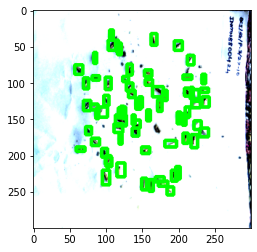

In [51]:
i = 11
img_id, image, ground_truth_box, ploc, plabel = img_ids[i], images[i], glocs[i], plocs[i], plabels[i]

im = np.transpose(image.numpy(), (1, 2, 0))
bbox = ground_truth_box.numpy()
bbox = (bbox * 300).astype(np.int32).tolist()
print (image.shape, ground_truth_box.shape, ploc.shape, plabel.shape)

plt.imshow(draw_multiple_rectangles(im, bbox, bbox_color=(0, 255, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


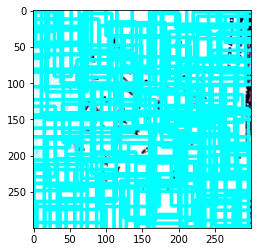

In [52]:
result = box_encoder.decode_batch(ploc.unsqueeze(0), plabel.unsqueeze(0), 0.3, 200)[0]
pred_bbox = result[0].detach().numpy()
pred_bbox = (pred_bbox * 300).astype(np.int32).tolist()

plt.imshow(draw_multiple_rectangles(im, pred_bbox))

#### Evaluate Metrics

In [63]:
# Create List[BoundingBox] format for pascal_voc_evaluator
pd_boxes = []
gt_boxes = []

# Loop through batch
for idx in range(len(glocs)):        
    gloc_i = glocs[idx]
    glabel_i = glabels[idx]

    if glabel_i.numel() == 0:
        continue

    gloc_i, glabel_i = gloc_i.detach().numpy(), glabel_i.detach().numpy().astype(np.int)
    for loc_, label_ in zip(gloc_i, glabel_i):
        gt_boxes.append(BoundingBox(image_name = img_ids[idx],
                class_id=str(label_),
                coordinates=(loc_[0], loc_[1], loc_[2], loc_[3]),
                type_coordinates=CoordinatesType.RELATIVE,
                img_size=(300, 300),
                bb_type=BBType.GROUND_TRUTH,
                format=BBFormat.XYX2Y2)) 


for idx in range(plocs.shape[0]):
    ploc_i = plocs[idx, :, :].unsqueeze(0)
    plabel_i = plabels[idx, :, :].unsqueeze(0)
    try:
        result = box_encoder.decode_batch(ploc_i, plabel_i, 0.3, 200)[0]
    except:
        print("No object detected in idx: {}".format(idx))
        continue
    
    loc, label, prob = [r.detach().numpy() for r in result]
    for loc_, label_, prob_ in zip(loc, label, prob):
        bbox = BoundingBox(image_name = img_ids[idx], 
                           class_id = str(label_),
                coordinates=(loc_[0], loc_[1], loc_[2], loc_[3]),
                type_coordinates=CoordinatesType.RELATIVE,
                img_size=(300, 300),
                bb_type=BBType.DETECTED,
                confidence=prob_,
                format=BBFormat.XYX2Y2)
        pd_boxes.append(bbox)      

In [64]:
out = get_pascalvoc_metrics(gt_boxes,
                          pd_boxes,
                          iou_threshold=0.4,
                          method=MethodAveragePrecision.EVERY_POINT_INTERPOLATION,
                          generate_table=False)
out['mAP']

0.001545782451139245

In [61]:
out['per_class']['1']['AP']

0.000689414821151348

In [175]:
[b._class_id for b in pd_boxes], [b._class_id for b in gt_boxes]

(['0', '0', '0'], ['0', '0', '1', '1', '1', '1'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


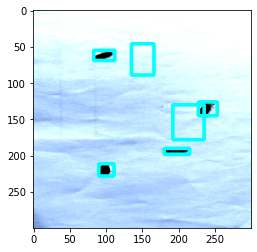

In [176]:
gt_boxes_post_process = [list(map(int, list((b.get_absolute_bounding_box(BBFormat.XYX2Y2))))) for b in gt_boxes]
plt.imshow(draw_multiple_rectangles(im, gt_boxes_post_process))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


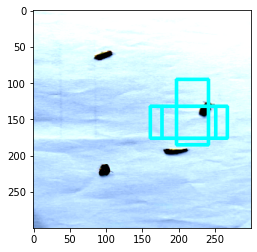

In [177]:
pd_boxes_post_process = [list(map(int, list((b.get_absolute_bounding_box(BBFormat.XYX2Y2))))) for b in pd_boxes]
plt.imshow(draw_multiple_rectangles(im, pd_boxes_post_process))

In [81]:
d = get_metrics(img_ids = img_ids,
                ploc = plocs, plabel = plabels, gloc = glocs, glabel = glabels,
                img_shape = (300, 300),
                nms_threshold = 0.5,
                max_num = 200,
                iou_threshold = 1e-7,
                encoder = box_encoder)

In [82]:
d

{'per_class': {'0.0': {'precision': array([], dtype=float64),
   'recall': array([], dtype=float64),
   'AP': 0,
   'interpolated precision': [0],
   'interpolated recall': [0],
   'total positives': 2,
   'total TP': 0.0,
   'total FP': 0.0,
   'method': <MethodAveragePrecision.EVERY_POINT_INTERPOLATION: 1>,
   'iou': 1e-07,
   'table': None},
  '1.0': {'precision': array([], dtype=float64),
   'recall': array([], dtype=float64),
   'AP': 0,
   'interpolated precision': [0],
   'interpolated recall': [0],
   'total positives': 4,
   'total TP': 0.0,
   'total FP': 0.0,
   'method': <MethodAveragePrecision.EVERY_POINT_INTERPOLATION: 1>,
   'iou': 1e-07,
   'table': None}},
 'mAP': 0.0}

(torch.Size([3, 300, 300]),
 torch.Size([13, 4]),
 torch.Size([4, 8732]),
 torch.Size([2, 8732]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


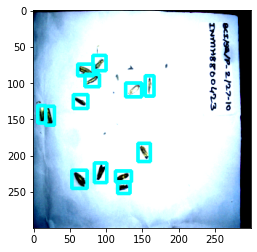

In [51]:
plt.imshow(draw_multiple_rectangles(im, bbox))

In [57]:
result = box_encoder.decode_batch(ploc.unsqueeze(0), plabel.unsqueeze(0), 0.2, 200)[0]

In [58]:
result[0].shape

torch.Size([44, 4])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


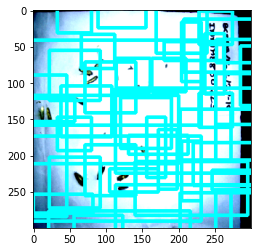

### Define Network

In [3]:
model: LightningModule = hydra.utils.instantiate(config.model,  model_config = config.model, _recursive_=False)

/root/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [7]:
# net(batch[0])